# Project goal & framing
## Business question

> “Given a member’s current profile and relationship with the bank,  
what is their risk of churn (Exited = 1) over the next 6–12 months,  
so that we can prioritize targeted retention actions?”

**Success looks like:**

- A model that **ranks members by churn risk** reliably (strong AUC & lift in top deciles);
- A **clear understanding of key churn drivers** (age, engagement, products, region, etc.) via SHAP;
- **Actionable segments and strategies** (e.g., who to contact, with what offers, and in which regions);
- Guardrails for **fairness & explainability** appropriate for a member-focused, regulated institution.

## Initial imports and setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

import os, sys

PROJECT_ROOT = os.path.abspath("..")  
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from churn_utils.io import save_processed_data, load_messy_churn_excel
from churn_utils.cleaning import clean_churn_dataframe
from churn_utils.modeling import prepare_data_and_pipelines
from churn_utils.evaluation import evaluate_classifier, lift_top_decile
from churn_utils.explain import (
    make_shap_explainer,
    shap_summary_plot,
    shap_local_explanation,
)
from churn_utils.viz import (
    plot_churn_rate,
    barplot_churn_by,
    distplot_feature,
)

## Load, Clean & Save

In [2]:
df_raw = load_messy_churn_excel()
df_clean = clean_churn_dataframe(df_raw)
save_processed_data(df_clean, "bank_churn_clean.csv")

Cleaned dataframe shape: (10004, 11)
Saved processed data to data/processed/bank_churn_clean.csv


## Exploratory Data Analysis (EDA)

### Overall churn rate

In [3]:
plot_churn_rate(df_clean)

Overall churn rate: 20.37%


**Overall churn rate**

> In this sample, the overall churn rate is 20.37% – roughly 1 in 5 customers left during the period.

This gives us a baseline to compare models against:

- If we did nothing smart and just guessed “no churn” for everyone, we’d still be wrong about 20% of the time.
- A good model should:
- Rank customers by risk,
- Concentrate as many of those churners as possible in the top risk decile or quintile, and
- Help us focus retention efforts on a small, high-risk segment instead of the entire population.

### Churn by Geography

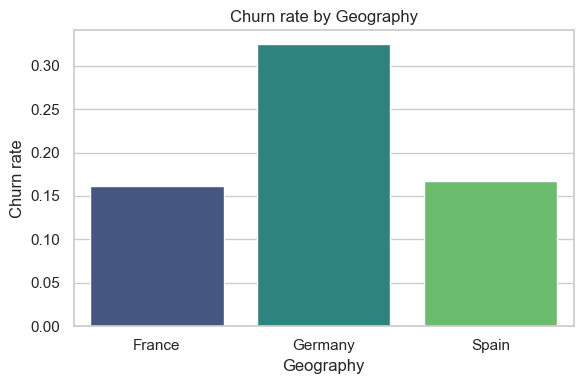

In [4]:
barplot_churn_by(df_clean, "Geography")

**Churn by geography**

> Members in Germany have roughly 2× the churn rate of members in France and Spain (≈32% vs 16–17%). This suggests that:

- There may be country-specific factors (competitive landscape, pricing, service differences) driving attrition.
- A “one-size-fits-all” retention strategy is unlikely to be optimal.

### Churn by Engagement (`IsActiveMember`)

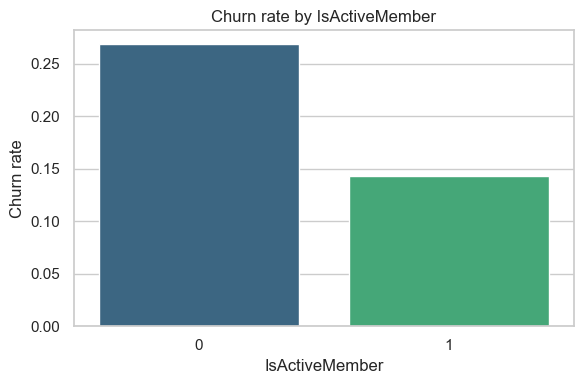

In [5]:
barplot_churn_by(df_clean, "IsActiveMember")

**Churn by engagement (IsActiveMember)**
> Inactive members churn at about 27%, compared with 14% for active members – roughly 2× higher risk.

This confirms that engagement is a strong protective factor. It suggests that:

- We should track an engagement score and
- Use it as an early-warning signal: declining activity is a leading indicator of churn, not just a symptom.

### Credit Score vs Churn

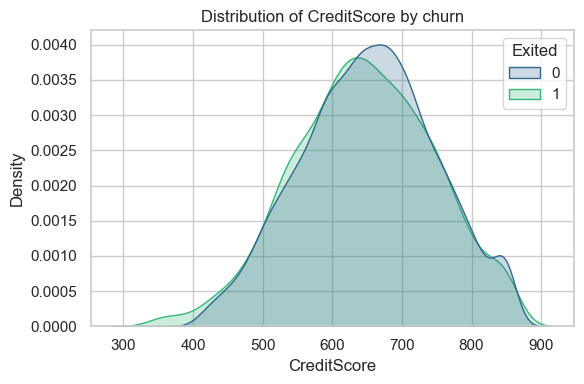

In [6]:
distplot_feature(df_clean, "CreditScore")

**Credit score and churn**

> The credit score distributions for churned and retained members are broadly similar, with churners skewing slightly toward lower scores.

Interpretation:

- Credit score has some relationship with churn (lower-scored members slightly more likely to leave),
- but it’s not as discriminative as geography or engagement on its own.

### Churn by Age

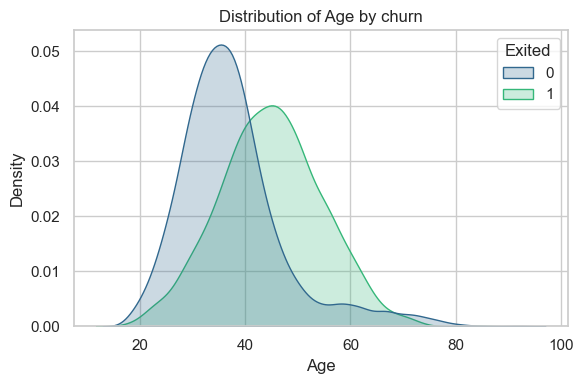

In [7]:
distplot_feature(df_clean, "Age")

**Age and churn**

> The age distribution for churned members is clearly shifted to the right compared to retained members.

- Retained members are concentrated in their 30s.
- Churned members are more likely to be in their 40s and 50s, with a noticeable tail into the 60s.

This suggests that older customers are more likely to churn in this dataset. Operationally, that might mean:

- Needs and expectations change as customers age (e.g., retirement planning, different product mix).

- Our offers or servicing model may be more tuned to mid-career customers than to late-career / pre-retirement ones.


## Prepare data & pipelines (includes feature engineering)

In [8]:
X_train, X_test, y_train, y_test, logreg_pipe, rf_pipe, xgb_pipe = (
    prepare_data_and_pipelines(df_clean)
)

## Train & evaluate Logistic Regression

In [9]:
logreg_pipe.fit(X_train, y_train)
y_proba_lr = logreg_pipe.predict_proba(X_test)[:, 1]
auc_lr = evaluate_classifier(y_test, y_proba_lr, threshold=0.5)
lift_lr = lift_top_decile(y_test.to_numpy(), y_proba_lr, top_fraction=0.1)

ROC-AUC: 0.839
Classification report @ threshold 0.5
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      2390
           1       0.46      0.72      0.56       612

    accuracy                           0.77      3002
   macro avg       0.69      0.75      0.70      3002
weighted avg       0.82      0.77      0.79      3002

Baseline churn rate: 20.386%
Top 10% segment churn rate: 75.333%
Lift: 3.70x


**Logistic Regression performance**

> The baseline churn rate in the test set is 20.4%, so if we guessed “no churn” for everyone we’d still be wrong about 1 in 5 customers.

> The logistic regression model achieves a ROC–AUC of 0.84, meaning that in ~84% of random churn/non-churn pairs, the churner gets a higher risk score than the non-churner.

At a 0.5 decision threshold:

- We correctly identify about 72% of churners (recall),
- With a precision of 46%, i.e., roughly half of the customers we flag as high risk actually do churn.
- Overall accuracy is 77%, but for this use case recall and lift are more important than raw accuracy.
- When we look at the top 10% of customers by predicted churn risk, the observed churn rate is 75.3%, vs 20.4% overall — a 3.7× lift.
- In other words, the model concentrates ~3.7 times more churners into the top decile than we’d expect at random.
- Roughly speaking, in a population of 100 members with 20 churners, about 7–8 of those churners would sit in the top 10 highest-risk scores, meaning we can catch ~40% of churners by contacting only 10% of members.


## Train & evaluate Random Forest

In [10]:
rf_pipe.fit(X_train, y_train)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]
auc_rf = evaluate_classifier(y_test, y_proba_rf, threshold=0.5)
lift_rf = lift_top_decile(y_test.to_numpy(), y_proba_rf, top_fraction=0.1)

ROC-AUC: 0.850
Classification report @ threshold 0.5
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2390
           1       0.55      0.68      0.61       612

    accuracy                           0.82      3002
   macro avg       0.73      0.77      0.75      3002
weighted avg       0.84      0.82      0.83      3002

Baseline churn rate: 20.386%
Top 10% segment churn rate: 74.000%
Lift: 3.63x


**Random Forest performance**

> Random Forest improves the AUC from 0.84 (logistic) to 0.85, so it captures more non-linear relationships and interactions than logistic regression.

At a 0.5 threshold it sits between logistic and XGBoost:

- Precision on churners: 0.55 (better than logistic’s 0.46, lower than XGB’s 0.74)
- Recall on churners: 0.68 (a bit lower than logistic’s 0.72, higher than XGB’s 0.47)
- Accuracy: 0.82 (between logistic’s 0.77 and XGB’s 0.86).
- In the top 10% highest-risk members, churn rate is 74.0% vs 20.4% overall, giving a 3.63× lift (better than logistic’s 3.70× baseline, slightly below XGBoost’s 3.97×).

Overall, Random Forest offers a nice balance of recall and precision, but XGBoost still gives the best ranking and lift in the highest-risk decile.

## Fit XGBoost model

In [11]:
xgb_pipe.fit(X_train, y_train)
y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

auc_xgb = evaluate_classifier(y_test, y_proba_xgb, threshold=0.5)
lift_xgb = lift_top_decile(y_test.to_numpy(), y_proba_xgb, top_fraction=0.1)

ROC-AUC: 0.863
Classification report @ threshold 0.5
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2390
           1       0.74      0.47      0.57       612

    accuracy                           0.86      3002
   macro avg       0.81      0.71      0.74      3002
weighted avg       0.85      0.86      0.85      3002

Baseline churn rate: 20.386%
Top 10% segment churn rate: 81.000%
Lift: 3.97x


**XGBoost performance**

> XGBoost improves AUC from 0.84 (logistic) to 0.86, so it does a better job ranking churn–vs–non-churn members.

At a 0.5 threshold, it’s more conservative than logistic:

- Precision on churners increases from 0.46 → 0.74 (fewer false positives),
- Recall on churners decreases from 0.72 → 0.47 (we miss more churners at this threshold),
- Overall accuracy rises from 0.77 → 0.86.

In terms of business value, the key metric is lift:
- Overall churn rate is 20.4%.
- In the top 10% of members ranked by XGBoost, churn rate is 81.0% (vs 75.3% for logistic), giving a 3.97× lift (vs 3.70×).
- That means if we only contact the top 10% highest-risk members, almost 4 times as many of them churn as we would expect at random, making outreach much more targeted and cost-effective.

Operationally, XGBoost is the best ranking model here; we can then tune the decision threshold depending on whether the business wants to maximize recall (catch more churners) or maximize precision (avoid false alarms).

### Simple comparison table

In [ ]:
summary = pd.DataFrame(
    [
        ["Logistic Regression", auc_lr, lift_lr],
        ["Random Forest", auc_rf, lift_rf],
        ["XGBoost", auc_xgb, lift_xgb],
    ],
    columns=["Model", "AUC", "Lift@10%"],
)
summary
summary_rounded = summary.copy()
summary_rounded["AUC"] = summary_rounded["AUC"].round(3)
summary_rounded["Lift@10%"] = summary_rounded["Lift@10%"].round(2)
summary_rounded["Comment"] = [
    "Baseline, linear & interpretable",
    "Non-linear, good balance P/R",
    "Best ranking & lift; final choice",
]
summary_rounded

,Model,AUC,Lift@10%,Comment
0,Logistic Regression,0.839,3.70,"Baseline, linear & interpretable"
1,Random Forest,0.850,3.63,"Non-linear, good balance P/R"
2,XGBoost,0.863,3.97,Best ranking & lift; final choice


## SHAP explainer for XGB

In [13]:
explainer, X_bg_transformed, feature_names = make_shap_explainer(xgb_pipe, X_train)

## Global summary plot

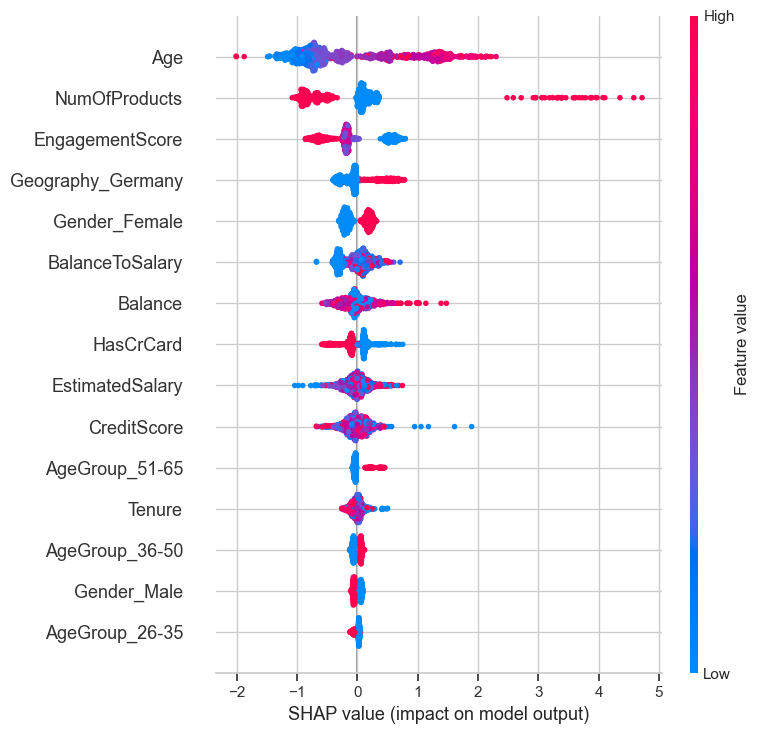

In [ ]:
plt.figure()
shap_summary_plot(
    explainer,
    X_bg_transformed,
    feature_names=feature_names,
    max_display=15,
)

### Global drivers of churn (SHAP summary plot)

The SHAP summary plot shows the **overall impact** of each feature on the model’s churn
predictions:

- **Age** is the strongest driver: older customers consistently have higher SHAP values,
  meaning **higher age → higher churn risk**, while younger members tend to be more stable.
- **NumOfProducts** captures relationship depth: customers with **fewer products**
  (especially single-product) are pushed toward higher churn risk, while multi-product
  customers are less likely to leave.
- **EngagementScore / IsActiveMember** acts as a protective factor: **low engagement**
  (blue points on the right) raises churn risk; **high engagement** (red on the left)
  lowers it.
- **Geography_Germany** has positive SHAP values, indicating that being in this region
  increases churn risk even after controlling for other factors.
- Financial profile variables like **BalanceToSalary**, **Balance**, and **CreditScore**
  matter, but they have **smaller effects** compared with age, products, engagement,
  and geography.
- Dummied **age groups** and **tenure** reinforce that older, shorter-tenure relationships
  are more fragile than younger, longer-tenure ones.

Overall, the model has learned a consistent story:  
**older, low-engagement, single-product customers in the high-churn region with certain
balance patterns are most at risk**, while younger, highly engaged, multi-product
customers in lower-churn regions are the most stable.

## Local explanation for a single test example

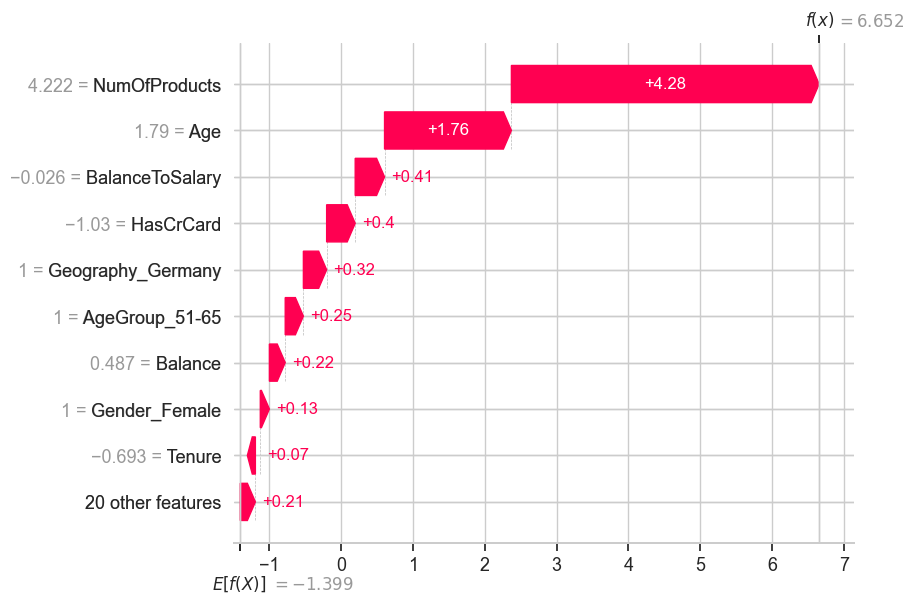

In [ ]:
# get predicted probabilities for test
if "y_proba_xgb" not in locals():
    y_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

high_risk_idx = np.argsort(-y_proba_xgb)[0]  # index of highest predicted churn
example_row = X_test.iloc[[high_risk_idx]]

shap_local_explanation(
    explainer,
    xgb_pipe,
    example_row,
    feature_names=feature_names,
)

### Local explanation for a high-risk member (SHAP waterfall)

The SHAP waterfall plot explains a **single member** with very high predicted churn
probability:

- The model starts from the **average churn risk (~20%)** and then adjusts based on this
  member’s characteristics.
- Their **NumOfProducts** and **Age** are the two biggest contributors, strongly pushing
  the prediction **up** from the baseline.
- Additional positive contributions come from:
  - Being in the **high-churn geography** (Geography_Germany),
  - Falling into the **51–65 age group**,
  - Their **balance / balance-to-salary profile**,
  - Having a **credit card** and their **gender**.
- Tenure and other smaller features give minor additional pushes upward.

Combined, these effects move this member from a typical ~20% risk to **near-certain
churn**, clearly flagging them as someone who should be **prioritized for retention
outreach**.

## Conclusion

- Overall churn is ~**20%** (1 in 5 customers).
- EDA shows higher churn among **older**, **inactive**, **single-product** customers and in one **high-churn region**.
- Three models were compared in a unified pipeline:

| Model               | AUC   | Lift@10% |
|---------------------|-------|----------|
| Logistic Regression | 0.839 | 3.70×    |
| Random Forest       | 0.850 | 3.63×    |
| XGBoost             | 0.863 | 3.97×    |

- **XGBoost** is the best **ranking model**, concentrating ~**4×** more churners in the top 10% than random.
- SHAP shows that **Age, NumOfProducts, Engagement/IsActive, Geography, and balance ratios** are the main churn drivers.

## Recommendations / Next steps (real-world)

- **Data & features:** Add richer behavioral and time-based features (recent balance changes, digital activity, service interactions).
- **Modeling:**  
  - Calibrate probabilities for better “probability = risk” interpretation.  
  - Consider **ensembles** (e.g., stacking logistic + RF + XGBoost) and a **champion–challenger** setup.
- **Operations:**  
  - Turn scores into **risk tiers** and target outreach to high-risk segments.  
  - Run **A/B tests** to measure retention lift and ROI; monitor performance and drift over time.
- **Governance:** Use SHAP regularly to explain decisions and check for unfair impact across age/region segments.